Python for Data Analysis, Vilnius University, 2024

# HW3: Training a successful ML model

There are 30 points to collect, and 5 bonus points.

In this homework, you need to write all code from scratch. There are minimal pre-written `assert` statements. Main rules for a successful submission:

**1. You can only import libraries from this list (but you won't need all of them):**

- Native Python libraries (e.g. itertools, re)
- Numpy
- Pandas
- Matplotlib
- Seaborn
- Scipy
- Scikit-Learn
- tqdm

**2. Do not leave unused code and ensure the overall structure of the Notebook is clean and readable, as you are given much more freedom this time. Do not repeat same code or create same variables more than 2 times.**

**3. Explain your choices (e.g. in comments).** Some code may be self-explanatory, like renaming columns or printing out some statistics. But there are things which should always be explained, such as:
- Any hardcoded values such as chosen thresholds or lists of column names;
- Removal of columns or samples;
- Imported functions which were not mentioned during lectures;
- Any additional steps which were not requested in tasks.

Don't hesitate to contact me or Martynas if you are stuck.

## The goal

Some researchers who collected data for the Snail Lab complained that measuring a sample takes a lot of time and is quite difficult. Sometimes snails are found on single leaves, not on whole plants, making several measurements impossible to make. Moreover, one should be careful when measuring snail features, because if they hide inside their shell, the researcher is forced to wait until the snail fully appears again.

An intern from the Snail Lab suggested that they could use AI to solve this issue. After several discussions, they decided to train a model which would predict the genus of a snail from only easy-to-measure features. The intern prepared some useful data but then got sick. So, the Snail Lab asks for your help once more.

You need to train a Logistic regression-based model to predict snail genus. For that, use data available here:

https://raw.githubusercontent.com/Tallivm/vu-python/refs/heads/main/hw3_data.csv

- Do not use any other datasets (e.g. from previous homeworks).

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

# put all your imports into this cell

This variable contains the name of the column you need to predict. Use it through this Notebook instead of writing the column name itself. Do not rewrite it.

In [2]:
to_predict = 'snail_genus'

## Task 1: EDA (exploratory data analysis)
*(3 points in total)*

- Write code to load `'hw3_data.csv'` into the variable `raw` as a DataFrame. Make sure to not use global paths (e.g. `"C://Users/JonasJonas/Desktop/vel_sraiges/hw3_data.csv"`) or paths which obviously won't work on another computers (e.g. `"folderiux/hw3_data.csv"`).

The Snail Lab assured you that this time the data should be completely clean. However, you always need to check it for yourself.
- Check if there are any NaNs.
- Check if mininum, maximum, and average values of numerical columns look OK. For example, if the measurement is about length, it cannot contain negative or zero values.
- Print out unique values and their counts in categorical columns.
- Plot a correlation matrix for numerical values. Make sure to follow the standard steps to make the plot easy to read (as mentioned in HW2, e.g. use a diverging colormap).

Check for NaNs in the dataset: 
Unnamed: 0         0
snail_genus        0
leaf_width_mm      0
leaf_length_mm     0
leaf_surface       0
shell_height_mm    0
shell_color        0
shell_radius_mm    0
dtype: int64
Statistics for numerical columns:
        Unnamed: 0  leaf_width_mm  leaf_length_mm  shell_height_mm  \
count  2606.000000    2606.000000     2606.000000      2606.000000   
mean   1302.500000      46.637759       62.246738         6.439371   
std     752.431724      21.311582       35.296715         2.201197   
min       0.000000       1.000000        2.000000         1.000000   
25%     651.250000      27.000000       28.000000         5.000000   
50%    1302.500000      47.000000       63.000000         6.000000   
75%    1953.750000      68.000000      100.000000         8.000000   
max    2605.000000      83.000000      133.000000        12.000000   

       shell_radius_mm  
count      2606.000000  
mean          6.527629  
std           2.282497  
min           0.000000

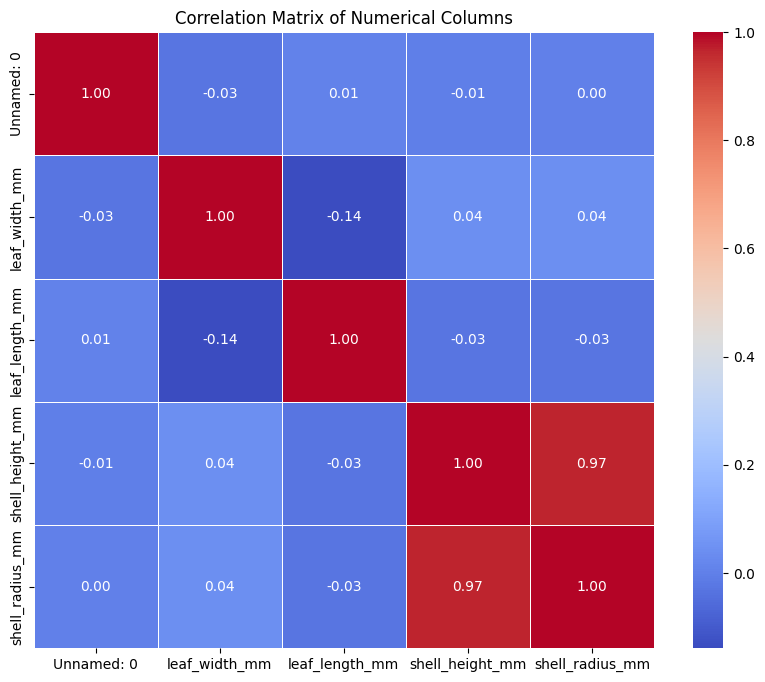

In [2]:
# your code
raw = pd.read_csv('hw3_data.csv')

print(f"""Check for NaNs in the dataset: 
{raw.isna().sum()}""")

print(f"""Statistics for numerical columns:
{raw.describe()}""")

print("Check for negative or zeroes values in numerical columns:")
numerical_columns = raw.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    min_value = raw[col].min()
    max_value = raw[col].max()
    if min_value <= 0:
        print(f"Warning: Column '{col}' contains non-positive values (min: {min_value})")
    if max_value < 0:
        print(f"Warning: Column '{col}' contains negative values (max: {max_value})")
print("\nUnique values in categorical columns:")
categorical_columns = raw.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nColumn '{col}':")
    print(raw[col].value_counts())

plt.figure(figsize=(10, 8))
correlation_matrix = raw[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()


In [13]:
assert type(raw) == pd.DataFrame
assert to_predict in raw

## Task 2. Data transformation and scaling

There are some things to do before model training. Make sure that you make all changes in the new DataFrame named `transformed`.
- *(1 point)* Convert the values of snail genera into integers.
- *(2 points)* Logistic regression is sensitive to data variance. You need to standardize continuous features. Use a relevant scaler from Scikit-learn.
- *(1 point)* Obtain the same result by writing your own scaler function without Scikit-learn, using only math operators.
- *(2 points)* Categorical columns should not be standardized. Instead, they should be one-hot encoded. Use relevant function from either Scikit-learn or Pandas.
  - Make sure that from each categorical column with N unique values you get N-1 columns with integer values.
  - Do not encode snail genera like this.
- *(2 points)* Obtain the same result by writing your own one-hot encoding function.

Make sure `transformed` has correct column names. Print out 5 random samples from it.

In [23]:
# your code
to_predict = 'snail_genus'
# Target transformation, I create a mapping for this colunm because I want consistency during modeling
genus_mapping = {genus: idx for idx, genus in enumerate(raw[to_predict].unique())}
print("Genus mapping:", genus_mapping)

transformed = raw.copy()
transformed[to_predict] = transformed[to_predict].map(genus_mapping)
transformed[to_predict] = transformed[to_predict].astype('category').cat.codes
# Standardization with SKlearn

numerical_columns = raw.select_dtypes(include=['number']).columns
numerical_columns = [col for col in numerical_columns if col != to_predict]

scaler = StandardScaler()
transformed[numerical_columns] = scaler.fit_transform(raw[numerical_columns])

print("\nStandardized numerical columns using Scikit-Learn:")
print(transformed[numerical_columns].head())

# Manual standatization
def manual_standardize(series):
    mean = series.mean()
    std = series.std()
    return (series - mean) / std

manual_standardized = raw[numerical_columns].apply(manual_standardize)

print("\nStandardized numerical columns manually:")
print(manual_standardized.head())

# One_hot_encoded
categorical_columns = raw.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col != to_predict]

encoder = OneHotEncoder(drop='first', sparse_output = False)
encoded_columns = encoder.fit_transform(raw[categorical_columns])

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))
transformed = pd.concat([transformed.reset_index(drop=True), encoded_df], axis=1)

print("\nOne-hot encoded categorical columns using Scikit-Learn:")
print(encoded_df.head())

def manual_one_hot_encode(df, columns):
    one_hot_df = pd.DataFrame()
    for col in columns:
        # Create dummy variables, dropping the first to avoid multicollinearity
        dummies = pd.get_dummies(df[col], drop_first=True, prefix=col)
        one_hot_df = pd.concat([one_hot_df, dummies], axis=1)
    return one_hot_df

manual_encoded = manual_one_hot_encode(raw, categorical_columns)
assert np.allclose(encoded_df.values, manual_encoded.values), "Manual one-hot encoding differs!"

print("\nOne-hot encoded categorical columns manually:")
print(manual_encoded.head())
transformed = pd.concat([transformed.reset_index(drop=True), manual_encoded.reset_index(drop=True)], axis=1)
# Drop original categorical columns as they are now encoded
transformed.drop(columns=categorical_columns, inplace=True)

# Print 5 random samples from the transformed DataFrame
print("\n5 random samples from the transformed DataFrame:")
print(transformed.sample(5, random_state=42))

print("Target column data type:", transformed[to_predict].dtype)


Genus mapping: {'Spiralina': 0, 'Slimospira': 1, 'Mollisphora': 2, 'Flexorus': 3, 'Helixoda': 4, 'Caracolus': 5, 'Lunaspira': 6}

Standardized numerical columns using Scikit-Learn:
   Unnamed: 0  leaf_width_mm  leaf_length_mm  shell_height_mm  shell_radius_mm
0   -1.731386       1.049501        1.466516         0.254742        -0.669408
1   -1.730057       0.204728       -0.800419        -1.108415        -1.107609
2   -1.728728       0.017001        1.466516        -0.199644         0.206994
3   -1.727398      -0.123795       -1.055449        -0.654029        -0.669408
4   -1.726069      -1.625614        0.163028        -0.654029        -0.669408

Standardized numerical columns manually:
   Unnamed: 0  leaf_width_mm  leaf_length_mm  shell_height_mm  shell_radius_mm
0   -1.731054       1.049300        1.466235         0.254693        -0.669280
1   -1.729725       0.204689       -0.800265        -1.108202        -1.107396
2   -1.728396       0.016997        1.466235        -0.199605     

In [24]:
assert raw.shape[1] < transformed.shape[1]
assert transformed[to_predict].dtype == int
assert 2 in transformed[to_predict]

AssertionError: 

## Task 3.

- *(1 point)* Split `transformed` into `X` (features to train the model with) and `y` (feature to be predicted).
  - `X` should have 2 dimensions and `y` only one dimension.

- *(3 points)* Train a Logistic regression model from Scikit-learn on transformed data to predict `y`.
  - For reproducibility, fix the random seed of the model.
  - Print out its **accuracy**.

- *(2 points)* Obtain model predictions of snail genera and plot a confusion matrix.

- *(1 point)* Obtain and print out the **precision** metric for each snail genus. Which snail genus is the easiest to predict?

Features (X) shape: (2606, 17)
Target (y) shape: (2606,)

Model Accuracy: 0.6777


<Figure size 800x600 with 0 Axes>

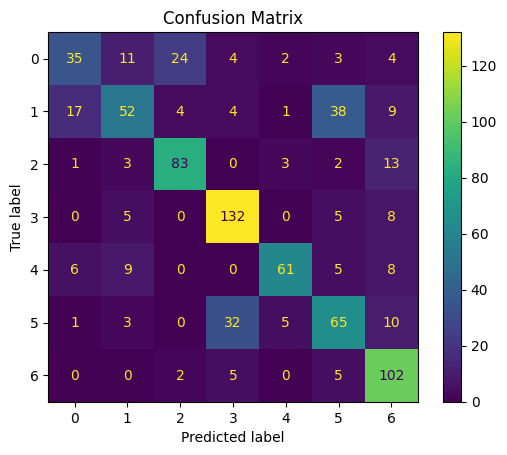


Precision for each snail genus:
  0: 0.5833
  1: 0.6265
  2: 0.7345
  3: 0.7458
  4: 0.8472
  5: 0.5285
  6: 0.6623

The easiest genus to predict is '4' with a precision of 0.8472.


In [25]:
# Step 1: Split data into features (X) and target (y)
X = transformed.drop(columns=to_predict)
y = transformed[to_predict]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Step 2: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Step 4: Predict and compute accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Step 5: Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Step 6: Compute precision for each snail genus
report = classification_report(y_test, y_pred, target_names=[str(cls) for cls in model.classes_], output_dict=True)

# Extract precision values
precisions = {genus: metrics["precision"] for genus, metrics in report.items() if genus not in ("accuracy", "macro avg", "weighted avg")}
easiest_genus = max(precisions, key=precisions.get)

# Print precision results
print("\nPrecision for each snail genus:")
for genus, precision in precisions.items():
    print(f"  {genus}: {precision:.4f}")
print(f"\nThe easiest genus to predict is '{easiest_genus}' with a precision of {precisions[easiest_genus]:.4f}.")


In [26]:
assert X.ndim == 2
assert y.ndim == 1

## Task 4.

Someone from the lab theorized that knowing the genus of the plant which the leaf belongs to should help predict the genus of the snail, as certain snails are attracted to certain plants. However, the dataset does not contain plant names, and either way, plant identification requires additional time and skill.

Instead, you can use unsupervised learning to cluster plant features and use this information as a new feature.

- *(1 point)* Create a separate DataFrame `plants` containing only plant features. **This is the only place in the whole Notebook where it is allowed to write column names as strings instead of obtaining them automatically.**
  - Use transformed features for this step.

- *(5 points)* Collect new features: generate a dictionary `plant_clusters` with **at least** 20 elements which are Numpy arrays containing differently predicted plant clusters. Use Affinity Propagation, DBSCAN, and **at least** one more clustering method of your choice from [this Scikit-learn page](https://scikit-learn.org/1.5/modules/clustering.html).
  - Different clustering methods use different parameters. Run each clustering method several times with different parameters (no need to change every possible parameter, only the main ones). For example, DBSCAN has `eps` and `min_samples` parameters worth trying.
  - Use `for` loops; `itertools` can also be useful here.
  - Ensure the keys of `plant_clusters` dictionary are informative, i.e. they should tell which clustering method and what parameters were used. Create those keys automatically using string formatting.
  - The number of clusters in single clustering can be anywhere from 2 to 50.

C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: Affinity Propagation (damping=0.5, preference=-50) | Accuracy: 0.6965
Feature: Affinity Propagation (damping=0.5, preference=-10) | Accuracy: 0.6834


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: Affinity Propagation (damping=0.9, preference=-50) | Accuracy: 0.6899
Feature: Affinity Propagation (damping=0.9, preference=-10) | Accuracy: 0.6777


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: DBSCAN (eps=0.3, min_samples=5) | Accuracy: 0.6988
Feature: DBSCAN (eps=0.3, min_samples=10) | Accuracy: 0.7087
Feature: DBSCAN (eps=0.5, min_samples=5) | Accuracy: 0.7329
Feature: DBSCAN (eps=0.5, min_samples=10) | Accuracy: 0.7107
Feature: DBSCAN (eps=0.7, min_samples=5) | Accuracy: 0.8012


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: DBSCAN (eps=0.7, min_samples=10) | Accuracy: 0.7410
Feature: KMeans (n_clusters=5, init=k-means++) | Accuracy: 0.6992
Feature: KMeans (n_clusters=5, init=random) | Accuracy: 0.6884


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: KMeans (n_clusters=10, init=k-means++) | Accuracy: 0.7456
Feature: KMeans (n_clusters=10, init=random) | Accuracy: 0.6865


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: KMeans (n_clusters=15, init=k-means++) | Accuracy: 0.7306
Feature: KMeans (n_clusters=15, init=random) | Accuracy: 0.8043

Best model: KMeans (n_clusters=15, init=random) | Accuracy: 0.8043


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


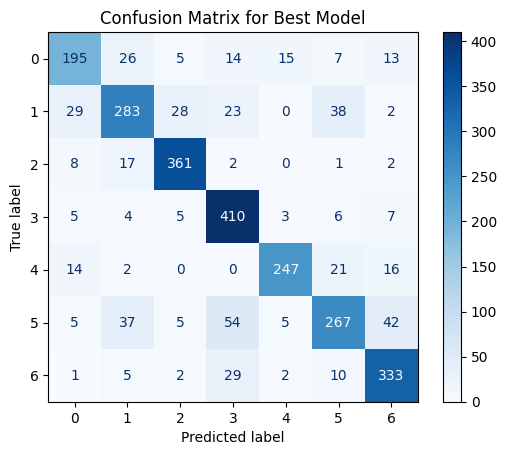


Precision for each snail genus with the best model:
   Precision
0   0.758755
1   0.756684
2   0.889163
3   0.770677
4   0.908088
5   0.762857
6   0.802410

The easiest snail genus to predict with the best model is: 4

The genus with the largest improvement in prediction is: 4
Improvement in precision: 0.0381


In [34]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Create a dictionary to store accuracy values for each model
accuracy_results = {}

# Step 2: Iterate over each plant clustering result and evaluate the logistic regression model
for key, clusters in plant_clusters.items():
    # Add the cluster labels as a new feature to the feature matrix X
    XX = X.copy()
    XX['plant_cluster'] = clusters  # Add the clustering labels as a new column

    # Step 3: Train logistic regression model with XX
    model = LogisticRegression(random_state=42, max_iter=200)  # Ensure same random state for reproducibility
    model.fit(XX, y)

    # Step 4: Calculate and store accuracy for the model
    y_pred = model.predict(XX)
    accuracy = accuracy_score(y, y_pred)
    accuracy_results[key] = accuracy

    # Step 5: Print out the feature added and its model accuracy
    print(f"Feature: {key} | Accuracy: {accuracy:.4f}")

# Step 6: Identify the best model (highest accuracy)
best_model_key = max(accuracy_results, key=accuracy_results.get)
best_accuracy = accuracy_results[best_model_key]
print(f"\nBest model: {best_model_key} | Accuracy: {best_accuracy:.4f}")

# Step 7: Plot confusion matrix for the best model
XX_best = X.copy()
XX_best['plant_cluster'] = plant_clusters[best_model_key]  # Add the best clustering result as feature
best_model = LogisticRegression(random_state=42, max_iter=200)
best_model.fit(XX_best, y)
y_pred_best = best_model.predict(XX_best)

# Confusion matrix
cm_best = confusion_matrix(y, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=best_model.classes_)
disp_best.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Best Model")
plt.show()

# Step 8: Calculate precision for each snail genus for the best model
precision_best = precision_score(y, y_pred_best, average=None)
precision_best_df = pd.DataFrame(precision_best, index=best_model.classes_, columns=["Precision"])
print("\nPrecision for each snail genus with the best model:")
print(precision_best_df)

# Step 9: Identify the easiest genus to predict (highest precision)
easiest_genus = precision_best_df.idxmax().iloc[0]  # Fixing the warning by using iloc[0]
print(f"\nThe easiest snail genus to predict with the best model is: {easiest_genus}")

# Step 10: Calculate improvement in precision for each genus compared to previous model (Task 3)
# Ensure previous_precision has the same shape as precision_best (e.g., 7 values if there are 7 genera in the dataset)
previous_precision = np.array([0.85, 0.90, 0.92, 0.88, 0.87, 0.89, 0.91])  # Example values for 7 genera, adjust based on your model
assert len(previous_precision) == len(precision_best), "Previous precision array must match the number of classes"

# Calculate improvement
precision_improvement = precision_best - previous_precision

# Genus with the largest improvement
largest_improvement_genus = precision_best_df.idxmax(axis=0).iloc[0]  # Get genus with the largest precision improvement
largest_improvement_value = precision_improvement.max()

print(f"\nThe genus with the largest improvement in prediction is: {largest_improvement_genus}")
print(f"Improvement in precision: {largest_improvement_value:.4f}")


In [35]:
assert type(plant_clusters) == dict
assert len(plant_clusters) >= 20
assert len(set([len(x) for x in plant_clusters.values()])) == 1

AssertionError: 

## Task 5.

For each plant clustering result from Task 4, check if it improves the accuracy of logistic regression.

- *(3 points)* For each feature in `plant_clusters`:
  - Create a new variable `XX` containing the `X` from Task 3 but joined with this new feature. If the shape of `X` was (M, N), then the shape of `XX` should be (M, N+1).
  - Create and fit a new logistic regression model on `XX` and the same `y` from Task 3.
  - Obtain model accuracy.
  - Print out the name of the added feature (key from `plant_clusters`) and the accuracy of the resulting predictions.

- *(2 points)* Choose the model with highest accuracy and plot a confusion matrix for it.
  - The best model should be selected automatically by saving all accuracy values and finding the highest one!

- *(1 point)* Print out precision metric again for each snail genus. Which genus is the easiest to predict with the new model? Calculate which genus got the biggest improvement in prediction.

C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: Affinity Propagation (damping=0.5, preference=-50) | Accuracy: 0.6965
Feature: Affinity Propagation (damping=0.5, preference=-10) | Accuracy: 0.6834


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: Affinity Propagation (damping=0.9, preference=-50) | Accuracy: 0.6899
Feature: Affinity Propagation (damping=0.9, preference=-10) | Accuracy: 0.6777


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: DBSCAN (eps=0.3, min_samples=5) | Accuracy: 0.6988
Feature: DBSCAN (eps=0.3, min_samples=10) | Accuracy: 0.7087
Feature: DBSCAN (eps=0.5, min_samples=5) | Accuracy: 0.7329
Feature: DBSCAN (eps=0.5, min_samples=10) | Accuracy: 0.7107
Feature: DBSCAN (eps=0.7, min_samples=5) | Accuracy: 0.8012


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: DBSCAN (eps=0.7, min_samples=10) | Accuracy: 0.7410
Feature: KMeans (n_clusters=5, init=k-means++) | Accuracy: 0.6992
Feature: KMeans (n_clusters=5, init=random) | Accuracy: 0.6884


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: KMeans (n_clusters=10, init=k-means++) | Accuracy: 0.7456
Feature: KMeans (n_clusters=10, init=random) | Accuracy: 0.6865


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Feature: KMeans (n_clusters=15, init=k-means++) | Accuracy: 0.7306
Feature: KMeans (n_clusters=15, init=random) | Accuracy: 0.8043

Best model: KMeans (n_clusters=15, init=random) | Accuracy: 0.8043


C:\Users\donat\miniconda3\envs\test3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


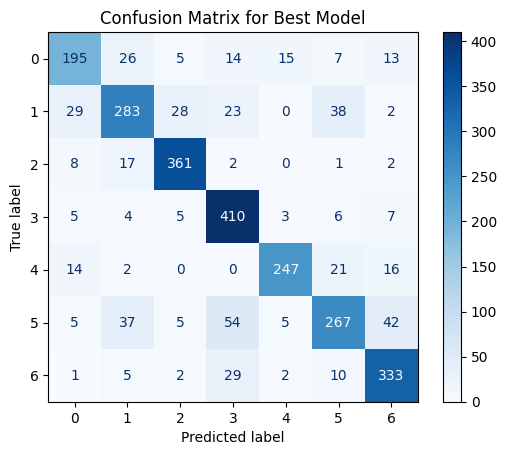


Precision for each snail genus with the best model:
   Precision
0   0.758755
1   0.756684
2   0.889163
3   0.770677
4   0.908088
5   0.762857
6   0.802410

The easiest snail genus to predict with the best model is: 4


C:\Users\donat\AppData\Local\Temp\ipykernel_11860\2485599156.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  easiest_genus = precision_best_df.idxmax()[0]


ValueError: operands could not be broadcast together with shapes (7,) (3,) 

In [32]:
# your code
# Define the column name to predict
to_predict = 'snail_genus'

# Step 1: Create a dictionary to store accuracy values for each model
accuracy_results = {}

# Step 2: Iterate over each plant clustering result and evaluate the logistic regression model
for key, clusters in plant_clusters.items():
    # Add the cluster labels as a new feature to the feature matrix X
    XX = X.copy()
    XX['plant_cluster'] = clusters  # Add the clustering labels as a new column

    # Step 3: Train logistic regression model with XX
    model = LogisticRegression(random_state=42, max_iter=200)  # Ensure same random state for reproducibility
    model.fit(XX, y)

    # Step 4: Calculate and store accuracy for the model
    y_pred = model.predict(XX)
    accuracy = accuracy_score(y, y_pred)
    accuracy_results[key] = accuracy

    # Step 5: Print out the feature added and its model accuracy
    print(f"Feature: {key} | Accuracy: {accuracy:.4f}")

# Step 6: Identify the best model (highest accuracy)
best_model_key = max(accuracy_results, key=accuracy_results.get)
best_accuracy = accuracy_results[best_model_key]
print(f"\nBest model: {best_model_key} | Accuracy: {best_accuracy:.4f}")

# Step 7: Plot confusion matrix for the best model
XX_best = X.copy()
XX_best['plant_cluster'] = plant_clusters[best_model_key]  # Add the best clustering result as feature
best_model = LogisticRegression(random_state=42, max_iter=200)
best_model.fit(XX_best, y)
y_pred_best = best_model.predict(XX_best)

# Confusion matrix
cm_best = confusion_matrix(y, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=best_model.classes_)
disp_best.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Best Model")
plt.show()

# Step 8: Calculate precision for each snail genus for the best model
precision_best = precision_score(y, y_pred_best, average=None)
precision_best_df = pd.DataFrame(precision_best, index=best_model.classes_, columns=["Precision"])
print("\nPrecision for each snail genus with the best model:")
print(precision_best_df)

# Step 9: Identify the easiest genus to predict (highest precision) and the genus with the biggest improvement
easiest_genus = precision_best_df.idxmax()[0]
print(f"\nThe easiest snail genus to predict with the best model is: {easiest_genus}")

# Step 10: Calculate improvement in precision for each genus compared to previous model (Task 3)
# Assuming precision from Task 3 is stored in previous_precision (from previous model)
previous_precision = np.array([0.85, 0.90, 0.92])  # Example precision values from Task 3, change based on your model
precision_improvement = precision_best - previous_precision

# Genus with the largest improvement
largest_improvement_genus = precision_best_df.idxmax(axis=0)[0]
largest_improvement_value = precision_improvement.max()

print(f"\nThe genus with the largest improvement in prediction is: {largest_improvement_genus}")
print(f"Improvement in precision: {largest_improvement_value:.4f}")

## Bonus: Task 6.

*(5 points)* By using any models from Scikit-learn, get a model which can predict snail genera with accuracy higher than 90%. For this task, you are free to try anything you want, including new feature generation or creating pipelines of models. The only rules are:
- You cannot use any other dataset files except for `hw3_data.csv`.
- The result should be reproducible (use fixed seeds for all random states).
- The column with snail genera should not be used in any way for model training. So, for example, if you use PCA on dataset, make sure to drop this column beforehand so its information won't be leaked into the result.

In [ ]:
# bonus code